# **Stable Diffusion Lab: Text to Image Generation**

**Introduction**

In this lab, we'll explore the fascinating world of text-to-image generation using Stable Diffusion, a powerful deep learning model. We'll break down the process step-by-step, understand the key components, and see how they work together to create images from text descriptions.

**What is Stable Diffusion?**

Stable Diffusion is a type of *diffusion model*. Diffusion models are trained to remove noise from images gradually. To generate an image, they reverse this process: starting with random noise and progressively refining it into a coherent image based on a text prompt.

**The Stable Diffusion Pipeline**

The Stable Diffusion pipeline consists of several key components:

1. **Text Encoder (CLIP):** Converts the text prompt into a numerical representation (embeddings) that captures the meaning of the text.
2. **Diffusion Model (UNet):** The core of the system. It iteratively denoises a random noise image, guided by the text embeddings, to produce the final image.
3. **Image Decoder (Autoencoder):** Transforms the denoised output from the diffusion model (which is in a compressed, "latent" space) into a full-resolution image in pixel space.
4. **Image Encoder (Autoencoder):** Compresses input image into latent space, so the diffusion model can use it.

**Let's get started!**

## **Setup**

First, we need to import the necessary libraries and set up the Stable Diffusion model.

In [1]:
import numpy as np
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras

from stable_diffusion_tf.diffusion_model import UNetModel
from stable_diffusion_tf.clip_encoder import CLIPTextTransformer
from stable_diffusion_tf.clip_tokenizer import SimpleTokenizer
from stable_diffusion_tf.autoencoder_kl import Decoder, Encoder
from stable_diffusion_tf.constants import _UNCONDITIONAL_TOKENS, _ALPHAS_CUMPROD
from PIL import Image

MAX_TEXT_LEN = 77

2025-01-29 18:07:23.054419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738192043.076422  856128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738192043.082774  856128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 18:07:23.104782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Helper Functions**

Before we dive into the main process, let's define some helper functions that will be used throughout the lab:

In [2]:
def timestep_embedding(timesteps, dim=320, max_period=10000):
    """
    Creates a positional embedding for timesteps.

    Args:
        timesteps: An array of timesteps for which to create embeddings.
        dim: The dimensionality of the embeddings.
        max_period: The maximum period of the sine and cosine functions.

    Returns:
        A tensor of shape (len(timesteps), dim) containing the timestep embeddings.
    """
    half = dim // 2
    freqs = np.exp(
        -math.log(max_period) * np.arange(0, half, dtype="float32") / half
    )
    args = np.array(timesteps) * freqs
    embedding = np.concatenate([np.cos(args), np.sin(args)])
    return tf.convert_to_tensor(embedding.reshape(1, -1),dtype=tf.float32)

def add_noise(x , t , noise=None ):
    """
    Adds noise to the input tensor 'x' based on the timestep 't'.

    Args:
        x: The input tensor.
        t: The timestep, which determines the amount of noise to add.
        noise: Optional noise tensor. If None, random noise will be generated.

    Returns:
        The input tensor with added noise.
    """
    batch_size,w,h = x.shape[0] , x.shape[1] , x.shape[2]
    if noise is None:
        noise = tf.random.normal((batch_size,w,h,4), dtype=tf.float32)
    sqrt_alpha_prod = _ALPHAS_CUMPROD[t] ** 0.5
    sqrt_one_minus_alpha_prod = (1 - _ALPHAS_CUMPROD[t]) ** 0.5

    return  sqrt_alpha_prod * x + sqrt_one_minus_alpha_prod * noise


def get_models(img_height, img_width, download_weights=True):
    """
    Creates and loads the Stable Diffusion models.

    Args:
        img_height: The height of the images.
        img_width: The width of the images.
        download_weights: Whether to download the pre-trained weights.

    Returns:
        A tuple containing the text encoder, diffusion model, decoder, and encoder.
    """
    n_h = img_height // 8
    n_w = img_width // 8

    # Create text encoder
    input_word_ids = keras.layers.Input(shape=(MAX_TEXT_LEN,), dtype="int32")
    input_pos_ids = keras.layers.Input(shape=(MAX_TEXT_LEN,), dtype="int32")
    embeds = CLIPTextTransformer()([input_word_ids, input_pos_ids])
    text_encoder = keras.models.Model([input_word_ids, input_pos_ids], embeds)

    # Creation diffusion UNet
    context = keras.layers.Input((MAX_TEXT_LEN, 768))
    t_emb = keras.layers.Input((320,))
    latent = keras.layers.Input((n_h, n_w, 4))
    unet = UNetModel()
    diffusion_model = keras.models.Model(
        [latent, t_emb, context], unet([latent, t_emb, context])
    )

    # Create decoder
    latent = keras.layers.Input((n_h, n_w, 4))
    decoder = Decoder()
    decoder = keras.models.Model(latent, decoder(latent))

    inp_img = keras.layers.Input((img_height, img_width, 3))
    encoder = Encoder()
    encoder = keras.models.Model(inp_img, encoder(inp_img))

    if download_weights:
        text_encoder_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/text_encoder.h5",
            file_hash="d7805118aeb156fc1d39e38a9a082b05501e2af8c8fbdc1753c9cb85212d6619",
        )
        diffusion_model_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/diffusion_model.h5",
            file_hash="a5b2eea58365b18b40caee689a2e5d00f4c31dbcb4e1d58a9cf1071f55bbbd3a",
        )
        decoder_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/decoder.h5",
            file_hash="6d3c5ba91d5cc2b134da881aaa157b2d2adc648e5625560e3ed199561d0e39d5",
        )

        encoder_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/divamgupta/stable-diffusion-tensorflow/resolve/main/encoder_newW.h5",
            file_hash="56a2578423c640746c5e90c0a789b9b11481f47497f817e65b44a1a5538af754",
        )

        text_encoder.load_weights(text_encoder_weights_fpath)
        diffusion_model.load_weights(diffusion_model_weights_fpath)
        decoder.load_weights(decoder_weights_fpath)
        encoder.load_weights(encoder_weights_fpath)
    return text_encoder, diffusion_model, decoder , encoder

**Function Explanations:**

*   **`timestep_embedding(timesteps, dim=320, max_period=10000)`:**
    *   This function creates *positional embeddings* for the timesteps used in the diffusion process.
    *   Think of it like encoding the concept of "time" (or how much noise is present) into a format that the model can understand.
    *   It uses sine and cosine functions with different frequencies to create unique embeddings for each timestep.
*   **`add_noise(x, t, noise=None)`:**
    *   This function adds a specific amount of Gaussian noise to an input tensor `x`.
    *   The amount of noise added is determined by the timestep `t`. Early timesteps in the diffusion process have less noise, while later timesteps have more noise.
    *   `_ALPHAS_CUMPROD` is a pre-calculated array that helps determine the noise schedule (how much noise to add at each timestep).
*   **`get_models(img_height, img_width, download_weights=True)`:**
    *   This is a utility function that creates instances of the four main models we need:
        *   **`text_encoder`:**  The CLIP text encoder.
        *   **`diffusion_model`:** The UNet diffusion model.
        *   **`decoder`:** The decoder part of the autoencoder.
        *   **`encoder`:** The encoder part of the autoencoder.
    *   It also handles downloading the pre-trained weights for these models if `download_weights` is set to `True`.

## **Instantiate the model**

In [3]:
# Instantiate the model (downloading weights)
img_height = 512
img_width = 512
text_encoder, diffusion_model, decoder, encoder = get_models(img_height, img_width, download_weights=True)

# You can comment this out if you don't want to use mixed precision
# Mixed precision uses float16 for computation, which can be faster on some GPUs
# print("Using mixed precision.")
# keras.mixed_precision.set_global_policy("mixed_float16")

I0000 00:00:1738192061.531677  856128 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


## **Step 1: Text Encoding**

Let's start with the text prompt. We'll use the CLIP text encoder to convert our prompt into embeddings.

In [9]:
# Our text prompt
prompt = "a realistic photograph of an astronaut riding a horse on Mars"

# 1. Tokenize the prompt
tokenizer = SimpleTokenizer()
text_inputs = tokenizer.encode(prompt)

# Pad the tokens to the maximum length (77)
text_inputs = text_inputs + [49407] * (77 - len(text_inputs))
text_inputs = np.array(text_inputs)[None]

# 2. Create positional IDs
pos_ids = np.array(list(range(77)))[None]

# 3. Get the text embeddings using the text encoder
context = text_encoder.predict_on_batch([text_inputs, pos_ids])

print("Text embedding shape:", context.shape)
# (1, 77, 768) means:
# 1 batch
# 77 tokens
# 768-dimensional embedding for each token

Text embedding shape: (1, 77, 768)


**Explanation:**

*   The `tokenizer` converts the text into numerical tokens (token IDs).
*   We pad the token sequence to a fixed length of 77 tokens, which is the maximum that CLIP can handle.
*   `pos_ids` are positional encodings that tell the model the order of the tokens in the sequence.
*   The `text_encoder` (CLIP) outputs a 768-dimensional vector for each token, representing the meaning of the token in the context of the entire prompt.

## **Step 2: The Diffusion Process (Simplified)**

The diffusion model (UNet) is the core of the image generation process. It takes a noisy image and the text embeddings as input and predicts the noise that was added to the image. By iteratively subtracting the predicted noise, we can gradually denoise the image.

Here's a simplified illustration of a single denoising step:

In [10]:
# Let's create a sample noisy image (latent representation)
n_h = img_height // 8
n_w = img_width // 8
noisy_latent = tf.random.normal((1, n_h, n_w, 4))

# Choose a timestep (e.g., 500) - this represents the amount of noise
timestep = 500

# Create the timestep embedding
t_emb = timestep_embedding(np.array([timestep]))

# We also need an unconditional embedding (for classifier-free guidance)
unconditional_tokens = np.array(_UNCONDITIONAL_TOKENS)[None]
unconditional_context = text_encoder.predict_on_batch(
    [unconditional_tokens, pos_ids]
)

# Get the model's prediction (noise estimate)
noise_pred = diffusion_model.predict_on_batch([noisy_latent, t_emb, context])
unconditional_noise_pred = diffusion_model.predict_on_batch([noisy_latent, t_emb, unconditional_context])

# Classifier-free guidance: combine conditional and unconditional predictions
guidance_scale = 7.5  # You can adjust this
noise_pred = unconditional_noise_pred + guidance_scale * (
    noise_pred - unconditional_noise_pred
)

# Simplified denoising step (using a simplified formula)
a_t = _ALPHAS_CUMPROD[timestep]
a_prev = _ALPHAS_CUMPROD[timestep - 1] if timestep > 0 else _ALPHAS_CUMPROD[0]
sqrt_one_minus_at = math.sqrt(1 - a_t)
pred_x0 = (noisy_latent - sqrt_one_minus_at * noise_pred) / math.sqrt(a_t)
dir_xt = math.sqrt(1.0 - a_prev) * noise_pred
denoised_latent = math.sqrt(a_prev) * pred_x0 + dir_xt

print("Denoised latent shape:", denoised_latent.shape)

Denoised latent shape: (1, 64, 64, 4)


**Explanation:**

*   We start with a random noise image in the latent space.
*   The `timestep` determines how much noise is present in the image. Higher timesteps mean more noise.
*   The `timestep_embedding` encodes the timestep into a vector that the model can understand.
*   The `diffusion_model` predicts the noise that was added to the image.
*   We perform a simplified denoising step using the predicted noise and the current `timestep`.
*   Classifier-free guidance enhances the effect of the prompt by combining the model's prediction with an unconditional prediction (as if there were no prompt).

## **Step 3: Image Decoding**

After multiple denoising steps (usually 20-50), the diffusion model produces a denoised latent representation of the image. We use the decoder to transform this back into a pixel-space image.


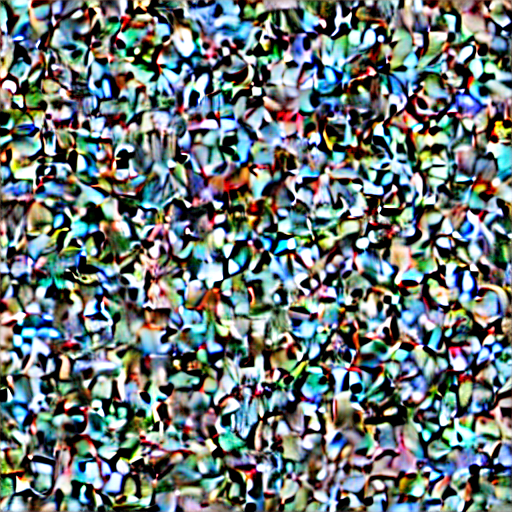

In [11]:
#'denoised_latent' is the output after multiple denoising steps
# Decode the latent representation into an image
decoded_image = decoder.predict_on_batch(denoised_latent)

# Scale and clip the pixel values to 0-255 range
decoded_image = ((decoded_image + 1) / 2) * 255
decoded_image = np.clip(decoded_image, 0, 255).astype("uint8")

# Display the image
Image.fromarray(decoded_image[0])

**Explanation:**

*   The `decoder` is trained to reconstruct an image from its latent representation.
*   We scale the decoded pixel values from the range \[-1, 1] to \[0, 255] for display.

## **Step 4: Generating an image using the full pipeline**

Here we combine all of the previous steps to generate an image from a text prompt.

In [12]:
def get_x_prev_and_pred_x0(x, e_t, index, a_t, a_prev, temperature, seed):
    """
    Predicts the previous (denoised) sample 'x_prev' and the predicted initial sample 'pred_x0'.

    Args:
        x: The current sample (latent).
        e_t: The model's estimated noise for the current sample.
        index: The index of the current timestep in the diffusion schedule.
        a_t: The value of alpha_cumprod at the current timestep.
        a_prev: The value of alpha_cumprod at the previous timestep.
        temperature: The temperature for sampling.
        seed: The random seed.

    Returns:
        A tuple containing the predicted previous sample 'x_prev' and the predicted initial sample 'pred_x0'.
    """
    sigma_t = 0
    sqrt_one_minus_at = math.sqrt(1 - a_t)
    pred_x0 = (x - sqrt_one_minus_at * e_t) / math.sqrt(a_t)

    # Direction pointing to x_t
    dir_xt = math.sqrt(1.0 - a_prev - sigma_t**2) * e_t
    noise = sigma_t * tf.random.normal(x.shape, seed=seed) * temperature
    x_prev = math.sqrt(a_prev) * pred_x0 + dir_xt
    return x_prev, pred_x0
    
def get_starting_parameters(timesteps, batch_size, seed, input_image=None):
    """
    Generates the initial parameters for the diffusion process.

    Args:
        timesteps: The timesteps used in the diffusion schedule.
        batch_size: The batch size.
        seed: The random seed.
        input_image: Optional initial image. If None, random noise is used.

    Returns:
        A tuple containing the initial latent, the alpha values, and the previous alpha values.
    """
    n_h = img_height // 8
    n_w = img_width // 8
    alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
    alphas_prev = [1.0] + alphas[:-1]
    if input_image is None:
        latent = tf.random.normal((batch_size, n_h, n_w, 4), seed=seed)
    else:
        latent = encoder(input_image)
        latent = tf.repeat(latent , batch_size , axis=0)
        latent = add_noise(latent, input_img_noise_t)
    return latent, alphas, alphas_prev

def get_model_output(
    latent,
    t,
    context,
    unconditional_context,
    unconditional_guidance_scale,
    batch_size,
):
    """
    Gets the model's output (estimated noise) for a given latent, timestep, and context.

    Args:
        latent: The current latent.
        t: The current timestep.
        context: The conditional context (text embeddings).
        unconditional_context: The unconditional context.
        unconditional_guidance_scale: The classifier-free guidance scale.
        batch_size: The batch size.

    Returns:
        The model's output (estimated noise).
    """
    timesteps = np.array([t])
    t_emb = timestep_embedding(timesteps)
    t_emb = np.repeat(t_emb, batch_size, axis=0)
    unconditional_latent = diffusion_model.predict_on_batch(
        [latent, t_emb, unconditional_context]
    )
    latent = diffusion_model.predict_on_batch([latent, t_emb, context])
    return unconditional_latent + unconditional_guidance_scale * (
        latent - unconditional_latent
    )

def generate_image(prompt, negative_prompt=None, num_steps=25, unconditional_guidance_scale=7.5,
                   temperature=1, batch_size=1, seed=None, input_image=None, input_image_strength=0.5):
    """
    Generates an image from a text prompt using the Stable Diffusion pipeline.

    Args:
        prompt: The text prompt.
        negative_prompt: An optional negative text prompt.
        num_steps: The number of diffusion steps.
        unconditional_guidance_scale: The classifier-free guidance scale.
        temperature: The temperature for sampling.
        batch_size: The batch size.
        seed: The random seed.
        input_image: Optional initial image.
        input_image_strength: The strength of the initial image (for image-to-image generation).

    Returns:
        The generated image as a NumPy array.
    """

    # 1. Tokenize the prompt
    inputs = tokenizer.encode(prompt)
    assert len(inputs) < 77, "Prompt is too long (should be < 77 tokens)"
    phrase = inputs + [49407] * (77 - len(inputs))
    phrase = np.array(phrase)[None].astype("int32")
    phrase = np.repeat(phrase, batch_size, axis=0)

    # 2. Encode prompt tokens into a "context vector"
    pos_ids = np.array(list(range(77)))[None].astype("int32")
    pos_ids = np.repeat(pos_ids, batch_size, axis=0)
    context = text_encoder.predict_on_batch([phrase, pos_ids])

    # 3. Tokenize negative prompt or use default padding tokens
    unconditional_tokens = _UNCONDITIONAL_TOKENS
    if negative_prompt is not None:
        inputs = tokenizer.encode(negative_prompt)
        assert len(inputs) < 77, "Negative prompt is too long (should be < 77 tokens)"
        unconditional_tokens = inputs + [49407] * (77 - len(inputs))
    unconditional_tokens = np.array(unconditional_tokens)[None].astype("int32")
    unconditional_tokens = np.repeat(unconditional_tokens, batch_size, axis=0)
    unconditional_context = text_encoder.predict_on_batch(
        [unconditional_tokens, pos_ids]
    )

    # 4. Define the timesteps
    timesteps = np.arange(1, 1000, 1000 // num_steps)

    # 5. Get the starting latent
    latent, alphas, alphas_prev = get_starting_parameters(
        timesteps, batch_size, seed
    )

    # 6. Diffusion process
    progbar = tqdm(list(enumerate(timesteps))[::-1])
    for index, timestep in progbar:
        progbar.set_description(f"{index:3d} {timestep:3d}")
        e_t = get_model_output(
            latent,
            timestep,
            context,
            unconditional_context,
            unconditional_guidance_scale,
            batch_size,
        )
        a_t, a_prev = alphas[index], alphas_prev[index]
        latent, pred_x0 = get_x_prev_and_pred_x0(
            latent, e_t, index, a_t, a_prev, temperature, seed
        )

    # 7. Decoding stage
    decoded = decoder.predict_on_batch(latent)
    decoded = ((decoded + 1) / 2) * 255
    return np.clip(decoded, 0, 255).astype("uint8")


**Function Explanations (Continued):**

*   **`get_x_prev_and_pred_x0(x, e_t, index, a_t, a_prev, temperature, seed)`:**
    *   This function performs a single step of the denoising process, predicting the previous sample (`x_prev`) and the predicted initial sample (`pred_x0`).
    *   It takes the current latent (`x`), the model's noise estimate (`e_t`), the timestep index (`index`), and other parameters related to the diffusion schedule.
    *   The formulas used here are derived from the DDPM (Denoising Diffusion Probabilistic Models) paper and are used to reverse the noise addition process.
*   **`get_starting_parameters(timesteps, batch_size, seed, input_image=None)`:**
    *   This function initializes the starting parameters for the diffusion process.
    *   If `input_image` is `None`, it creates a random noise latent as the starting point.
    *   Otherwise, if an `input_image` is provided, it encodes it into the latent space using the `encoder` and adds an initial amount of noise, this is used for the image-to-image generation.
    *   It also calculates the `alphas` and `alphas_prev` values, which are used in the denoising formulas based on the chosen `timesteps`.
*   **`get_model_output(latent, t, context, unconditional_context, unconditional_guidance_scale, batch_size)`:**
    *   This function gets the diffusion model's output (the estimated noise) for a given `latent`, `timestep`, and `context` (text embeddings).
    *   It handles both conditional (with prompt) and unconditional (without prompt) predictions and combines them using the `unconditional_guidance_scale` for classifier-free guidance.
*   **`generate_image(...)`:**
    *   This is the main function that puts all the pieces together to generate an image from a text `prompt`.
    *   It performs the following steps:
        1. Tokenizes the prompt and encodes it into a context vector using the `text_encoder`.
        2. Tokenizes the `negative_prompt` (if provided) and gets its context vector.
        3. Defines the `timesteps` for the diffusion process.
        4. Gets the starting `latent` (either random noise or encoded from an `input_image`).
        5. Iterates through the `timesteps` in reverse order, performing the denoising steps using `get_model_output` and `get_x_prev_and_pred_x0`.
        6. Decodes the final `latent` into an image using the `decoder`.
        7. Returns the generated image.

## **Generate and display the image**

  0   1: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


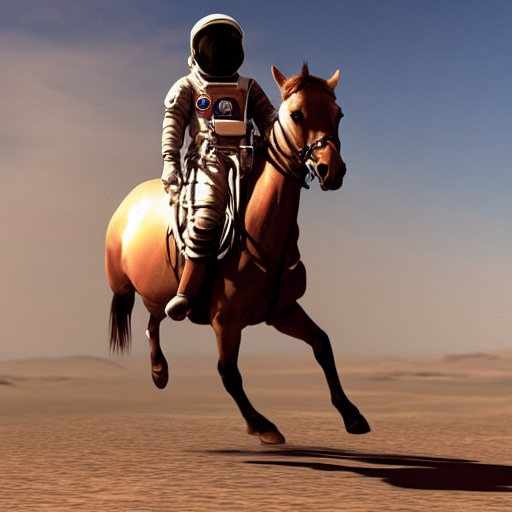

In [13]:
# Generate and display the image
img = generate_image(prompt, num_steps=25)
Image.fromarray(img[0])

**Experiment!**

Now comes the fun part! You can change the `prompt`, `num_steps`, `guidance_scale`, and `seed` to see how they affect the generated image. Here are some ideas:

*   **Prompt:** Try different text prompts, be creative! You can describe objects, scenes, styles, and even emotions.
*   **num\_steps:** This controls the number of denoising steps. More steps usually lead to better quality but take longer.
*   **unconditional_guidance_scale:** This parameter controls how strongly the model follows the prompt. Higher values make the model adhere more strictly to the prompt, but too high values can reduce image quality or diversity.
*   **Seed:** Changing the seed will produce different variations of the same image.
*   **Negative prompt:** Use the `negative_prompt` argument to specify what you *don't* want in the image.

**Conclusion**

In this lab, we explored the Stable Diffusion pipeline and learned how it generates images from text. We saw how the text encoder, diffusion model, and decoder work together, and we got to experiment with different parameters. This is just the beginning of what's possible with text-to-image generation. There's a whole world of research and creativity to explore!
